In [22]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import cluster
from sklearn.decomposition import PCA

from scipy.spatial import distance

In [32]:
##LOADING CLEANED DATA

train = pd.read_csv('train_players_cleaned.csv')
test = pd.read_csv('test_players_cleaned.csv')

#extract player-allstar columns
train_as = train[['Player_year', 'All-Star_caliber']]
test_as = test[['Player_year', 'All-Star_caliber']]

In [24]:
train.head()

,Unnamed: 0,Player_x,Pos_x,Age_x,Tm_x,G_x,GS,MP_x,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,Player_year,Year,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,All-Star_caliber
0,0,Jordan Adams\adamsjo01,SG,21,MEM,2,0,15,6.9,20.6,0.333,0.0,3.4,0.000,6.9,17.2,0.400,10.3,17.2,0.600,0.0,6.9,6.9,10.3,10.3,0.0,6.9,6.9,24.0,84.0,90,Jordan Adams\adamsjo01/2016,2016,17.3,0.427,0.167,0.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,0.015,-2.9,4.8,1.9,0.0,0
1,1,Steven Adams\adamsst01,C,22,OKC,80,80,2014,6.4,10.5,0.613,0.0,0.0,0.000,6.4,10.5,0.613,2.8,4.8,0.582,5.4,7.7,13.1,1.5,1.0,2.2,2.1,5.5,15.7,123.0,105,Steven Adams\adamsst01/2016,2016,15.5,0.621,0.000,0.460,12.5,16.1,14.4,4.3,1.0,3.3,14.1,12.6,4.2,2.3,6.5,0.155,0.8,1.3,2.1,2.1,1
2,2,Arron Afflalo\afflaar01,SG,30,NYK,71,57,2371,7.7,17.3,0.443,2.0,5.2,0.382,5.7,12.2,0.469,2.4,2.8,0.840,0.5,5.3,5.8,3.1,0.5,0.2,1.8,3.1,19.7,105.0,112,Arron Afflalo\afflaar01/2016,2016,10.9,0.531,0.298,0.164,1.1,11.0,6.1,9.9,0.5,0.3,8.7,17.9,1.8,0.9,2.7,0.055,-0.6,-1.8,-2.4,-0.2,0
3,3,Alexis Ajinca\ajincal01,C,27,NOP,59,17,861,8.6,18.1,0.476,0.0,0.1,0.000,8.6,18.1,0.478,3.0,3.6,0.839,4.3,11.2,15.5,1.8,1.1,2.1,3.1,7.7,20.3,100.0,107,Alexis Ajinca\ajincal01/2016,2016,13.8,0.514,0.003,0.197,9.3,25.9,17.3,5.8,1.1,3.4,13.6,20.4,0.2,0.9,1.0,0.058,-4.3,-0.2,-4.5,-0.5,0
4,4,Cole Aldrich\aldrico01,C,27,LAC,60,5,800,8.4,14.1,0.596,0.0,0.0,0.000,8.4,14.1,0.596,3.8,5.3,0.714,5.4,12.7,18.0,3.1,2.9,4.3,4.0,8.7,20.5,113.0,94,Cole Aldrich\aldrico01/2016,2016,21.3,0.626,0.000,0.373,11.9,27.1,19.6,10.0,2.9,6.7,19.6,18.4,1.4,2.0,3.5,0.209,-1.0,5.8,4.8,1.4,0


In [25]:
#FEATURE SELECTION

#DROP FEATURES THAT ARE RELATED TO PLAYER SUCCESS
## as_caliber, VORP, BPM, WS/48, WS, GS G_x, MP_x 

#FINAL FEATURE SELECTION ***********************
#MIX drop raw and percent metrics 
#keep OBMP DBPM, DROP TOV TOV%, keep ORD DRB TRB AST STL BLK - drop respective %, 
#                drop PTS so stars and high scorers and such won't get clustered together
#                replace FG% with TS%
train_select = train.drop(['Unnamed: 0','Age_x', 'FG','FGA','FG%','3P','3PA','2P','2PA','FT','FTA', 'PTS', 'ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV','TOV%','PER','All-Star_caliber', 'VORP', 'OBPM', 'DBPM', 'BPM', 'WS', 'WS/48', 'USG%', 'GS', 'G_x', 'MP_x'], axis = 1)
test_select = test.drop(['Unnamed: 0','Age_x', 'FG','FGA','FG%','3P','3PA','2P','2PA','FT','FTA', 'PTS', 'ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV','TOV%','PER','All-Star_caliber', 'VORP', 'OBPM', 'DBPM', 'BPM', 'WS', 'WS/48', 'USG%', 'GS', 'G_x', 'MP_x'], axis = 1)

test_select.head()

,Player_x,Pos_x,Tm_x,3P%,2P%,FT%,ORB,DRB,TRB,AST,STL,BLK,PF,ORtg,DRtg,Player_year,Year,TS%,3PAr,FTr,OWS,DWS
0,Alex Abrines\abrinal01,SG,OKC,0.323,0.500,0.923,0.4,3.4,3.8,1.6,1.3,0.5,4.2,103.0,111,Alex Abrines\abrinal01/2019,2019,0.507,0.809,0.083,0.1,0.6
1,Quincy Acy\acyqu01,PF,PHO,0.133,0.667,0.700,1.2,8.5,9.7,3.1,0.4,1.6,9.3,87.0,116,Quincy Acy\acyqu01/2019,2019,0.379,0.833,0.556,-0.1,0.0
2,Jaylen Adams\adamsja01,PG,ATL,0.338,0.361,0.778,1.2,5.3,6.5,7.0,1.5,0.5,4.9,99.0,115,Jaylen Adams\adamsja01/2019,2019,0.474,0.673,0.082,-0.1,0.2
3,Steven Adams\adamsst01,C,OKC,0.000,0.596,0.500,6.8,6.5,13.3,2.2,2.0,1.3,3.6,120.0,106,Steven Adams\adamsst01/2019,2019,0.591,0.002,0.361,5.1,4.0
4,Bam Adebayo\adebaba01,C,MIA,0.200,0.588,0.735,4.2,11.0,15.2,4.7,1.8,1.7,5.2,120.0,104,Bam Adebayo\adebaba01/2019,2019,0.623,0.031,0.465,3.4,3.4


In [70]:
##STANDARDIZE DATA FOR LDA
train_standardized  = pd.DataFrame(StandardScaler().fit_transform(train_select.select_dtypes(exclude='object')))
test_standardized  = pd.DataFrame(StandardScaler().fit_transform(test_select.select_dtypes(exclude='object')))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis(n_components=2, solver='svd' )
train_LDA = LDA.fit(train_standardized,train_select['Pos_x']).transform(train_standardized)
train_LDA = pd.DataFrame(train_LDA, columns = ['principal component 1', 'principal component 2' ])

test_LDA = LDA.transform(test_standardized)
test_LDA = pd.DataFrame(test_LDA, columns = ['principal component 1', 'principal component 2' ])

LDA.score(train_standardized,train_select['Pos_x'])


0.6280487804878049

For n_clusters = 2 The average silhouette_score is : 0.47472241777009166
For n_clusters = 3 The average silhouette_score is : 0.4878919816089325
For n_clusters = 4 The average silhouette_score is : 0.39171109325083164
For n_clusters = 5 The average silhouette_score is : 0.37995782847653703
For n_clusters = 6 The average silhouette_score is : 0.355910208778509
For n_clusters = 7 The average silhouette_score is : 0.35892004582760023
For n_clusters = 8 The average silhouette_score is : 0.3382010385979708
For n_clusters = 9 The average silhouette_score is : 0.33646703105130044


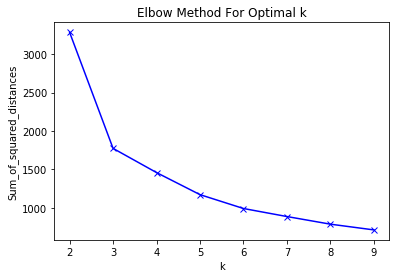

In [71]:
## Number of Cluster Analysis LDA = 2

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(train_LDA)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(train_LDA, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [72]:
##CLUSTER ANALYSIS

cluster_labels = {2:'Post-Heavy Big Man', 3:'Offensive Big Man', 7:'Pace & Space Forward', 0: 'Defensive Forward', 
                  6: '3 & D Wing', 4: 'Slashing Guard', 1: 'Combo Guard', 5:'Primary Distributing Ballhandler'}

k = 8
kmeans = cluster.KMeans(n_clusters=k, random_state = 1)
kmeans.fit(train_LDA)
train_cluster = kmeans.predict(train_LDA)
test_cluster = kmeans.predict(test_LDA)

train_LDA['Cluster'] = train_cluster
train_LDA['Cluster'] = train_LDA.apply(lambda row: cluster_labels[row.Cluster], axis=1)
train_LDA['Player'] = train_select['Player_year']

train_clustered = train_select.merge(train_LDA, left_on = 'Player_year', right_on = 'Player')
train_clustered = train_clustered.merge(train_as, left_on = 'Player_year', right_on = 'Player_year')
train_clustered = train_clustered.drop(['Player'], axis = 1) 

test_LDA['Cluster'] = test_cluster
test_LDA['Cluster'] = test_LDA.apply(lambda row: cluster_labels[row.Cluster], axis=1)
test_LDA['Player'] = test_select['Player_year']

test_clustered = test_select.merge(test_LDA, left_on = 'Player_year', right_on = 'Player')
test_clustered = test_clustered.merge(test_as, left_on = 'Player_year', right_on = 'Player_year')
test_clustered = test_clustered.drop(['Player'], axis = 1) 

all_players_clustered = train_clustered.append(test_clustered)

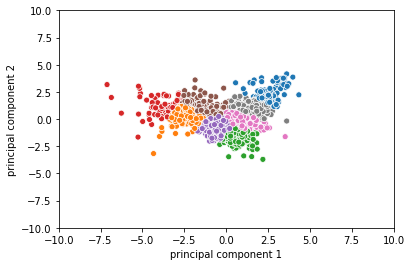

In [73]:
plt.figure()
plt.ylim(-10, 10)
plt.xlim(-10, 10)
sns.scatterplot(x='principal component 1', y ='principal component 2', hue ="Cluster", data = train_clustered, legend = False )


In [74]:
train_clustered.to_csv('train_players_clustered.csv')
test_clustered.to_csv('test_players_clustered.csv')
all_players_clustered.to_csv('all_players_clustered.csv')

In [75]:
all_players_clustered

,Player_x,Pos_x,Tm_x,3P%,2P%,FT%,ORB,DRB,TRB,AST,STL,BLK,PF,ORtg,DRtg,Player_year,Year,TS%,3PAr,FTr,OWS,DWS,principal component 1,principal component 2,Cluster,All-Star_caliber
0,Jordan Adams\adamsjo01,SG,MEM,0.000,0.400,0.600,0.0,6.9,6.9,10.3,10.3,0.0,6.9,84.0,90,Jordan Adams\adamsjo01/2016,2016,0.427,0.167,0.833,0.0,0.0,3.477375,2.241329,Primary Distributing Ballhandler,0
1,Steven Adams\adamsst01,C,OKC,0.000,0.613,0.582,5.4,7.7,13.1,1.5,1.0,2.2,5.5,123.0,105,Steven Adams\adamsst01/2016,2016,0.621,0.000,0.460,4.2,2.3,-2.927623,0.447064,Offensive Big Man,1
2,Arron Afflalo\afflaar01,SG,NYK,0.382,0.469,0.840,0.5,5.3,5.8,3.1,0.5,0.2,3.1,105.0,112,Arron Afflalo\afflaar01/2016,2016,0.531,0.298,0.164,1.8,0.9,0.790236,-1.041262,3 & D Wing,0
3,Alexis Ajinca\ajincal01,C,NOP,0.000,0.478,0.839,4.3,11.2,15.5,1.8,1.1,2.1,7.7,100.0,107,Alexis Ajinca\ajincal01/2016,2016,0.514,0.003,0.197,0.2,0.9,-2.921463,0.860691,Offensive Big Man,0
4,Cole Aldrich\aldrico01,C,LAC,0.000,0.596,0.714,5.4,12.7,18.0,3.1,2.9,4.3,8.7,113.0,94,Cole Aldrich\aldrico01/2016,2016,0.626,0.000,0.373,1.4,2.0,-4.057452,2.201391,Defensive Big Man,0
5,LaMarcus Aldridge\aldrila01,PF,SAS,0.000,0.521,0.858,4.0,10.3,14.3,2.5,0.9,1.8,3.4,114.0,99,LaMarcus Aldridge\aldrila01/2016,2016,0.565,0.015,0.289,5.6,4.5,-2.543673,0.270635,Offensive Big Man,1
6,Cliff Alexander\alexacl01,PF,POR,0.000,0.500,0.000,2.8,5.6,8.3,0.0,1.4,2.8,1.4,100.0,107,Cliff Alexander\alexacl01/2016,2016,0.500,0.000,0.000,0.0,0.0,-1.740933,-0.648292,Offensive Big Man,0
7,Lavoy Allen\allenla01,PF,IND,0.000,0.516,0.630,5.0,8.1,13.2,2.4,0.8,1.3,4.6,110.0,104,Lavoy Allen\allenla01/2016,2016,0.532,0.000,0.197,1.6,2.1,-1.873330,0.568011,Offensive Big Man,0
8,Tony Allen\allento01,SG,MEM,0.357,0.468,0.652,3.3,6.1,9.4,2.2,3.5,0.6,5.6,101.0,105,Tony Allen\allento01/2016,2016,0.505,0.090,0.294,0.5,1.9,-0.401893,-1.116091,Defensive Forward,0
9,Al-Farouq Aminu\aminual01,SF,POR,0.361,0.468,0.737,2.1,8.6,10.7,2.9,1.5,1.1,3.7,105.0,107,Al-Farouq Aminu\aminual01/2016,2016,0.533,0.485,0.217,1.7,2.3,-0.427400,-1.500272,Defensive Forward,0
